# 1A. Quick-start

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/16*

**Table of contents**

* [1.1. Loading ADI data](#1.1.-Loading-ADI-data)
    
* [1.2. Model PSF subtraction for ADI](#1.2.-Model-PSF-subtraction-for-ADI)
    - [1.2.1. median-ADI](#1.2.1.-median-ADI)
    - [1.2.2. Full-frame PCA](#1.2.2.-Full-frame-PCA)

This quick-start tutorial shows:

- how to load Angular Differential Imaging (ADI) datacubes; 
- how to use some of the algorithms implemented in VIP to model and subtract the stellar halo in order to produce final post-processed images.

-----------

Let's assume ``VIP`` and ``hciplot`` are properly installed. We import the packages along with other useful libraries:

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

In the following box we import all the routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

Parts of this notebook will *NOT* run for VIP versions below 1.0.0.

In [2]:
from packaging import version
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import normalize_psf
    from vip_hci.pca import pca
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import normalize_psf
    from vip_hci.psfsub import median_sub, pca
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.4.2


The ``hciplot`` package aims to be the "Swiss army" solution for plotting and visualizing multi-dimensional high-contrast imaging datacubes. It replaces the `vip_hci.var.pp_subplots` function present in older version of ``VIP``. `VIP` also allows interactive work with `DS9` provided that it's installed on your system along with ``pyds9``. A `DS9` session (window) can be started with: 

```ds9 = vip.Ds9Window()```

If the above fails but you have pyds9 installed (``vip_ds9`` is only a wrapper around ``pyds9``), you may find the [following troubleshooting tips](https://community.lsst.org/t/ds9-communication-via-xpa/2242) useful (e.g. step 4 in particular).

The *ds9* methods will allow interaction with the `DS9` window. For example, for sending an in-memory array to the `DS9` window you can simply use:

```ds9.display(2d_or_3d_array)```

The above can be used instead of ```hciplot```'s ```plot_frames``` and ```plot_cubes``` routines (the latter being used in this notebook) for visualization and interaction with your images/datacubes.

## 1.1. Loading ADI data

In order to demonstrate the capabilities of ``VIP``, you can find in the 'dataset' folder of the `VIP_extras` repository: a toy Angular Differential Imaging (ADI) datacube of images and a point spread function (PSF) associated to the NACO instrument of the Very Large Telescope (VLT). This is an L'-band VLT/NACO dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract), obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

Let's first inspect the fits file:

In [3]:
info_fits('../datasets/naco_betapic_cube_cen.fits')

Filename: ../datasets/naco_betapic_cube_cen.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (101, 101, 61)   float32   


The fits file contains an ADI datacube of 61 images 101x101 px across.

The parallactic angle vector for this observation is saved in the `naco_betapic_pa.fits` file. 

Now we load all the data in memory with the `open_fits` function:

In [4]:
psfname = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfname)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded, header available. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded, header available. Data shape: (39, 39)
Fits HDU-0 data successfully loaded, header available. Data shape: (61,)


`open_fits` is a wrapper of the `astropy` fits functionality. The fits file is now a ndarray or ``numpy`` array in memory.

If you open the datacube with ds9 (or send it to the `DS9` window) and adjust the cuts you will see the beta Pic b planet moving on a circular trajectory, among similarly bright quasi-static speckle. Alternatively, you can use `hciplot.plot_cubes`:

In [5]:
plot_cubes(cube, vmin=0, vmax=400)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 61]


BokehModel(combine_events=True, render_bundle={'docs_json': {'0da07182-d52e-4a6d-a760-32b0f683a1bc': {'version…

Note that the parallactic angles are not the final derotation angles to be applied to the images to match north up and east left. The following offsets, taken from Absil et al. (2013), are also added:

In [6]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa-derot_off-TN

Let's measure the Full-Width Half-Maximum (FWHM) by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

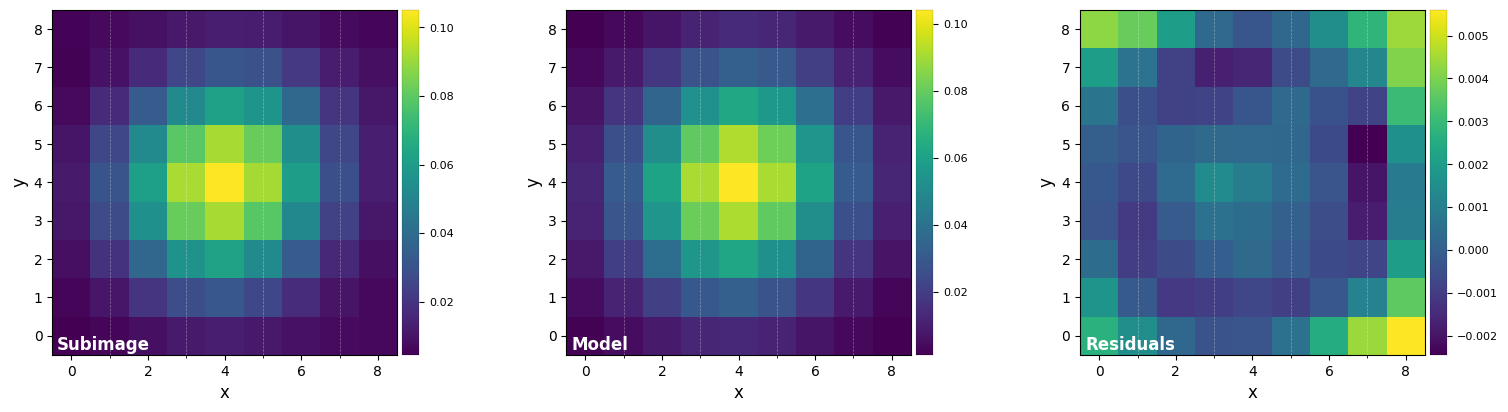

FWHM_y = 4.733218722257211
FWHM_x = 4.4736824050602895 

centroid y = 19.006680059041173
centroid x = 18.999424475165444
centroid y subim = 4.006680059041175
centroid x subim = 3.999424475165444 

amplitude = 0.10413004853269539
theta = -34.08563676834198


In [7]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [8]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.60345056365875


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [9]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


The `normalize_psf` function performs internally a fine centering of the PSF (note the input PSF should already be centered within a few pixel accuracy for this fine centering to work). The `imlib` argument sets the library to be used for sub-px shifts (more details in `Tutorial 7`).

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

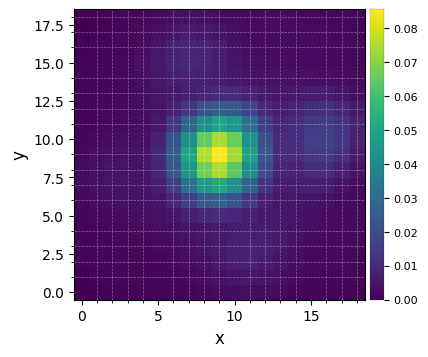

In [10]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [11]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 1.2. Model PSF subtraction for ADI

When loading the ADI cube above, we assumed all calibration and preprocessing steps were already performed. In particular, the star is assumed to be already centered in the images. If your data require calibration/preprocessing, feel free to check tutorial `2. Pre-processing` for example usage of VIP pre-processing routines on NACO and SPHERE/IFS data.

**IMPORTANT** - VIP's convention regarding centering is:
- for **odd** number of pixels along the x and y directions: the star is placed on the central pixel;
- for **even** number of pixels: the star is placed on coordinates (dim/2,dim/2) in 0-based indexing.

All ADI-based algorithms involve image rotation. We therefore first set the preferred method to be used for image rotation. This is controlled with the `imlib` and `interpolation` optional arguments (see Tutorial `7. FFT- vs. interpolation-based image operations` for more details). Feel free to adapt the following box to test other methods illustrated in Tutorial 7.

In [12]:
imlib = 'vip-fft' #'opencv'
interpolation=None # 'lanczos4'

### 1.2.1. median-ADI

The most simple approach is to model the PSF with the median of the ADI sequence, subtract it, then derotate and median-combine all residual images ([Marois et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract)):

In [13]:
fr_adi = median_sub(cube, angs, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-07 14:39:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:03.631446
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


This can also be done in concentric annuli of annular width `asize`, considering a parallactic angle threshold `delta_rot` and the `nframes` closest images complying with that criterion as model for subtraction to each image of the ADI cube:

In [14]:
fr_adi_an = median_sub(cube, angs, fwhm_naco, asize=fwhm_naco, mode='annular', delta_rot=0.5, 
                       radius_int=4, nframes=4, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-07 14:39:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4


Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:04.256179
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Note that the parallactic angle threshold corresponding to 0.5 FWHM linear motion could not be met for the innermost annulus, and was therefore automatically relaxed to find `nframes` eligible frames to be used for the model.

Let's visualize the final images:

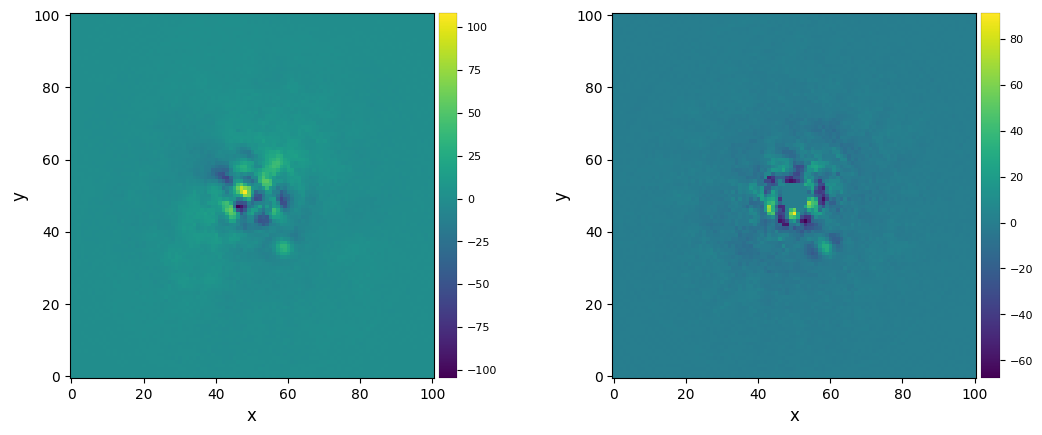

In [15]:
plot_frames((fr_adi, fr_adi_an))

Strong residuals can be seen near the center of the image, with a faint potential point source in the south-west of the final image.

[Go to the top](#Table-of-contents)

### 1.2.2. Full-frame PCA

Now let's try the Principal Component Analysis (PCA) algorithm ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)), and set to 5 the number of principal components `ncomp` considered for model creation.

In [16]:
fr_pca1 = pca(cube, angs, ncomp=5, mask_center_px=None, imlib=imlib, interpolation=interpolation,
              svd_mode='lapack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-07 14:39:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 25.047 GB
System available memory = 15.883 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.138798
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:03.832780
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the final image. This time let's set the `grid` option on, to better read coordinates from the image:

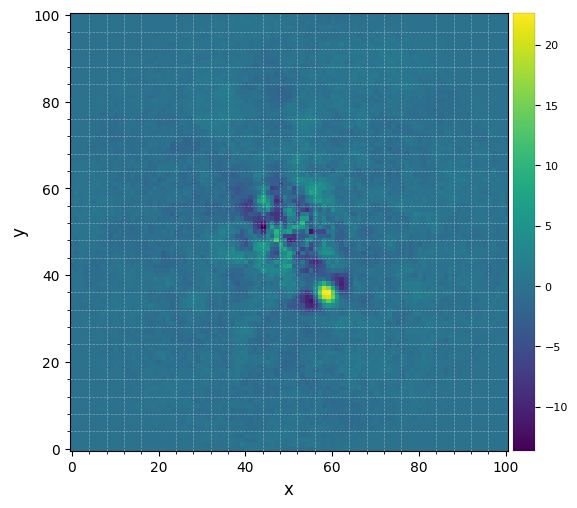

In [17]:
plot_frames(fr_pca1, grid=True)

The improvement is clear compared to previous reductions. Very low residuals are seen near the star, and the companion candidate appears as a bright point source surrounded by negative side-lobes.

Now let's see whether the candidate is significant. For that let's first set the x,y coordinates of the test point source based on the above image:

In [18]:
xy_b = (58.5,35.5)

Now let's compute the signal-to-noise ratio at that location, following the definition in [Mawet et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract).

In [19]:
snr1 = snr(fr_pca1, source_xy=xy_b, fwhm=fwhm_naco)
print(r"S/N = {:.1f}".format(snr1))

S/N = 8.1


One can also calculate a S/N ratio map over the whole image (this may take a couple of seconds depending on the size of your image):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-07 14:39:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


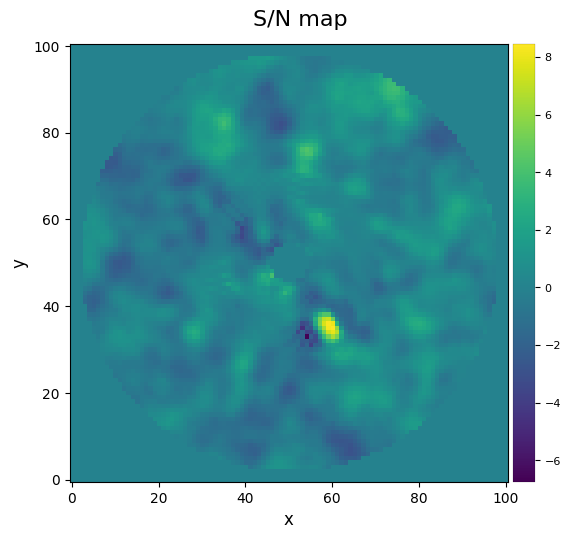

S/N map created using 2 processes
Running time:  0:00:11.567619
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [20]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=True)

Remember that S/N ratio is NOT the same as significance ([Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract)). Let's convert the measured S/N ratio (Students statistics) into a Gaussian "sigma" with equivalent false alarm probability. This first involves calculating the radial separation of the candidate:

In [21]:
cy, cx = frame_center(snrmap1)
rad = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)

Now let's use the `significance` routine in VIP to operate the conversion:

In [22]:
sig = significance(snr1, rad, fwhm_naco, student_to_gauss=True)
print(r"{:.1f} sigma detection".format(sig))

5.4 sigma detection


**Congratulations!** The detection is significant! You obtained a conspicuous direct image of an exoplanet! Although from this image alone (at a single wavelength) one cannot disentangle a true physically bound companion from a background star, this source has now been extensively studied: it corresponds to the giant planet Beta Pic b (e.g. [Lagrange et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...493L..21L/abstract), [Absil et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract)).

You're now ready for more advanced tutorials. If you wish to know more about:

- pre-processing functionalities available in VIP (star centering, bad frame trimming, bad pixel correction...) --> go to **Tutorial 2**;
- more advanced post-processing algorithms --> go to **Tutorial 3**;
- metrics to evaluate the significance of a detection or the achieved contrast in your image --> go to **Tutorial 4**;
- how to characterize a directly imaged companion --> go to **Tutorial 5**;
- how to characterize a circumstellar disk --> go to **Tutorial 6**;
- the difference between FFT- and interpolation-based image operations (rotation, shifts, scaling) --> go to **Tutorial 7**;
- the object-oriented implementation of VIP --> go to **Tutorial 8**.